In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
r = np.load("DandB_capture1.npy")[0:15] # 16th element is not connected
r_cal = np.load("C_only_capture1.npy")[0:15]

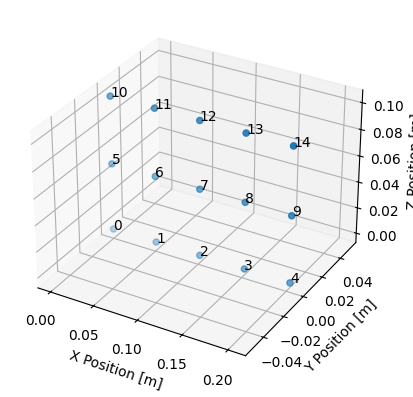

In [2]:
fc = 2.8e9 # center frequency in Hz
d = 0.051 # spacing between antennas in meters
wavelength = 3e8 / fc
Nr = 15
rows = 3
cols = 5

# Element positions, still as a list of x,y,z coordinates in meters
pos = np.zeros((Nr, 3))
for i in range(Nr):
    pos[i,0] = d * (i % cols)  # x position
    pos[i,1] = 0 # y position
    pos[i,2] = d * (i // cols) # z position

# Plot and label positions of elements, to sanity check
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pos[:,0], pos[:,1], pos[:,2], 'o')
# Labal indeces
for i in range(Nr):
    ax.text(pos[i,0], pos[i,1], pos[i,2], str(i), fontsize=10)
plt.xlabel("X Position [m]")
plt.ylabel("Y Position [m]")
ax.set_zlabel("Z Position [m]") # type: ignore
plt.grid()
plt.show()

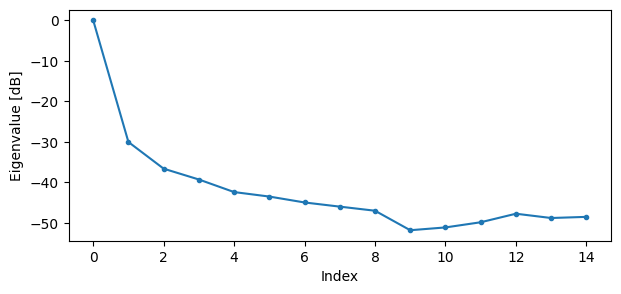

cal_table [ 1.        +0.j          0.99526771+0.76149029j -0.91754588-0.66825262j
 -0.96840297+0.37251012j  0.87866849+0.40446665j  0.56040169+1.50499875j
 -0.80109196-1.29299264j -1.28464742-0.31133052j  1.26622038+0.46047599j
  2.01855809+9.77121302j -0.29249322-1.09413205j -1.0372309 -0.17983522j
 -0.70614339+0.78682873j -0.75612972+5.67234809j  1.00032754-0.60824109j]


In [3]:
###############
# Calibration #
###############

# amplitude and phase offsets are found from the eigenvalue decomposition of the covariance matrix R
R_cal = r_cal @ r_cal.conj().T # Calc covariance matrix, it's Nr x Nr
w, v = np.linalg.eig(R_cal) # eigenvalue decomposition, v[:,i] is the eigenvector corresponding to the eigenvalue w[i]

# Plot eigenvalues
w_dB = 10*np.log10(np.abs(w))
w_dB -= np.max(w_dB) # normalize
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 3))
ax1.plot(w_dB, '.-')
ax1.set_xlabel('Index')
ax1.set_ylabel('Eigenvalue [dB]')
plt.show()

# Use max eigenvector to calibrate
v_max = v[:, np.argmax(np.abs(w))]
mags = np.mean(np.abs(r_cal), axis=1)
mags = mags[0] / mags # normalize to first element
phases = np.angle(v_max)
phases = phases[0] - phases # normalize to first element
cal_table = mags * np.exp(1j * phases)
print("cal_table", cal_table)

In [4]:
# Apply cal offsets to r
for i in range(Nr):
    r[i, :] *= cal_table[i]

C:\Users\marclichtman\AppData\Local\Temp\ipykernel_27604\1451152587.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[i, j] = music_metric


Text(0.5, 0, 'Power [dB]')

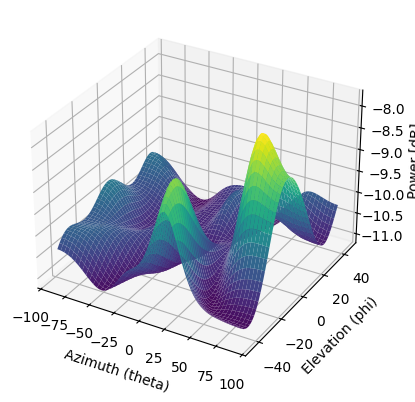

In [6]:
def steering_vector(pos, dir):
    return np.exp(-2j * np.pi * pos @ dir / wavelength) # outputs Nr x 1 (column vector)

def get_unit_vector(theta, phi):  # angles are in radians
    return np.asmatrix([np.sin(theta) * np.cos(phi), # x component
                        np.cos(theta) * np.cos(phi), # y component
                        np.sin(phi)]).T              # z component


resolution = 400 # number of points in each direction
theta_scan = np.linspace(-np.pi/2, np.pi/2, resolution) # azimuth angles
phi_scan = np.linspace(-np.pi/4, np.pi/4, resolution) # elevation angles
results = np.zeros((resolution, resolution)) # 2D array to store results
R = np.cov(r) # Covariance matrix, 15 x 15
Rinv = np.linalg.pinv(R)
expected_num_signals = 4 # for MUSIC only
w, v = np.linalg.eig(R) # eigenvalue decomposition, v[:,i] is the eigenvector corresponding to the eigenvalue w[i]
eig_val_order = np.argsort(np.abs(w))
v = v[:, eig_val_order] # sort eigenvectors using this order
V = np.zeros((Nr, Nr - expected_num_signals), dtype=np.complex64) # Noise subspace is the rest of the eigenvalues
for i in range(Nr - expected_num_signals):
    V[:, i] = v[:, i]
for i, theta_i in enumerate(theta_scan):
    for j, phi_i in enumerate(phi_scan):
        dir_i = get_unit_vector(theta_i, -1*phi_i) # TODO FIGURE OUT WHY I NEEDED TO NEGATE PHI FOR THE RESULTS TO MATCH REALITY
        s = steering_vector(pos, dir_i) # 15 x 1
        #w = s # Conventional beamformer
        music_metric = 1 / (s.conj().T @ V @ V.conj().T @ s)
        music_metric = np.abs(music_metric).squeeze()
        music_metric = np.clip(music_metric, 0, 2) # Useful for ABCD one
        results[i, j] = music_metric
        # MVDR/Capon
        #w = (Rinv @ s)/(s.conj().T @ Rinv @ s)
        #resp = w.conj().T @ r
        #results[i, j] = np.abs(resp)[0,0] # power in signal, in dB

# 3D
results = 10*np.log10(results) # convert to dB
results[results < -20] = -20 # crop the z axis to some level of dB
fig, ax = plt.subplots(subplot_kw={"projection": "3d", "computed_zorder": False})
surf = ax.plot_surface(np.rad2deg(theta_scan[:,None]), # type: ignore
                        np.rad2deg(phi_scan[None,:]),
                        results,
                        cmap='viridis')
#ax.set_zlim(-10, results[max_idx])
ax.set_xlabel('Azimuth (theta)')
ax.set_ylabel('Elevation (phi)')
ax.set_zlabel('Power [dB]') # type: ignore

Text(0, 0.5, 'Phi (elevation, degrees)')

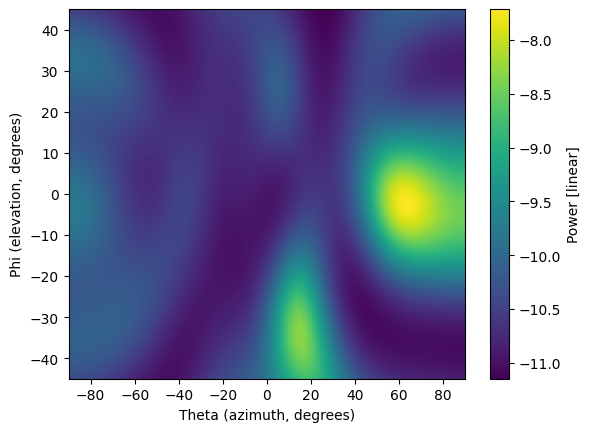

In [7]:
# 2D, theta-phi heatmap
extent=(np.min(theta_scan)*180/np.pi,
        np.max(theta_scan)*180/np.pi,
        np.min(phi_scan)*180/np.pi,
        np.max(phi_scan)*180/np.pi)
plt.imshow(results.T, extent=extent, origin='lower', aspect='auto', cmap='viridis') # type: ignore
plt.colorbar(label='Power [linear]')
plt.xlabel('Theta (azimuth, degrees)')
plt.ylabel('Phi (elevation, degrees)')